In [13]:
import matplotlib.colors as mcolors

# Your specific colors
color_list = ['#0283F8', '#FFA500','#00C49A', '#FF0059']
# Create a ListedColormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("CustomColormap", color_list)

colors = {
    "red":'#FF0059',
    "blue":'#0283F8',
    "green":'#00C49A',
    "orange":'#FFA500'
}

In [285]:
bounds = 8*np.pi
size = 500
x = np.linspace(0, bounds, size)
fx = np.sin(x) + np.random.normal(0, 0.1, size=(x.shape))

In [289]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

freqs, coefs, peaks = re.timeseries.find_frequency_peaks(
    fx, x, min_height=0.1, distance=1
)
# delays
rate = bounds / size
delays = np.linspace(0, 45 * rate, 100)
average_orth = [re.timeseries.gamma_value(tau, freqs[peaks]) for tau in delays]
min_delay = delays[np.argmin(average_orth)]
delay = int(min_delay // rate)


vandermond = re.timeseries.omega_matrix(min_delay, freqs[peaks])
sigma = svdvals(vandermond)
f_approx = re.timeseries.reconstruct_signal(coefs, peaks)
diff = np.abs(fx - f_approx)
lower_bound = np.sqrt(3) * np.max(np.abs(coefs[peaks])) * np.min(sigma) - np.sqrt(
    np.sum(peaks) + 1
) * np.max(diff)

# embedding
embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=delay)
bad_embedding = re.timeseries.time_delay_embedding(fx,dimension = np.sum(peaks),delay=2)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


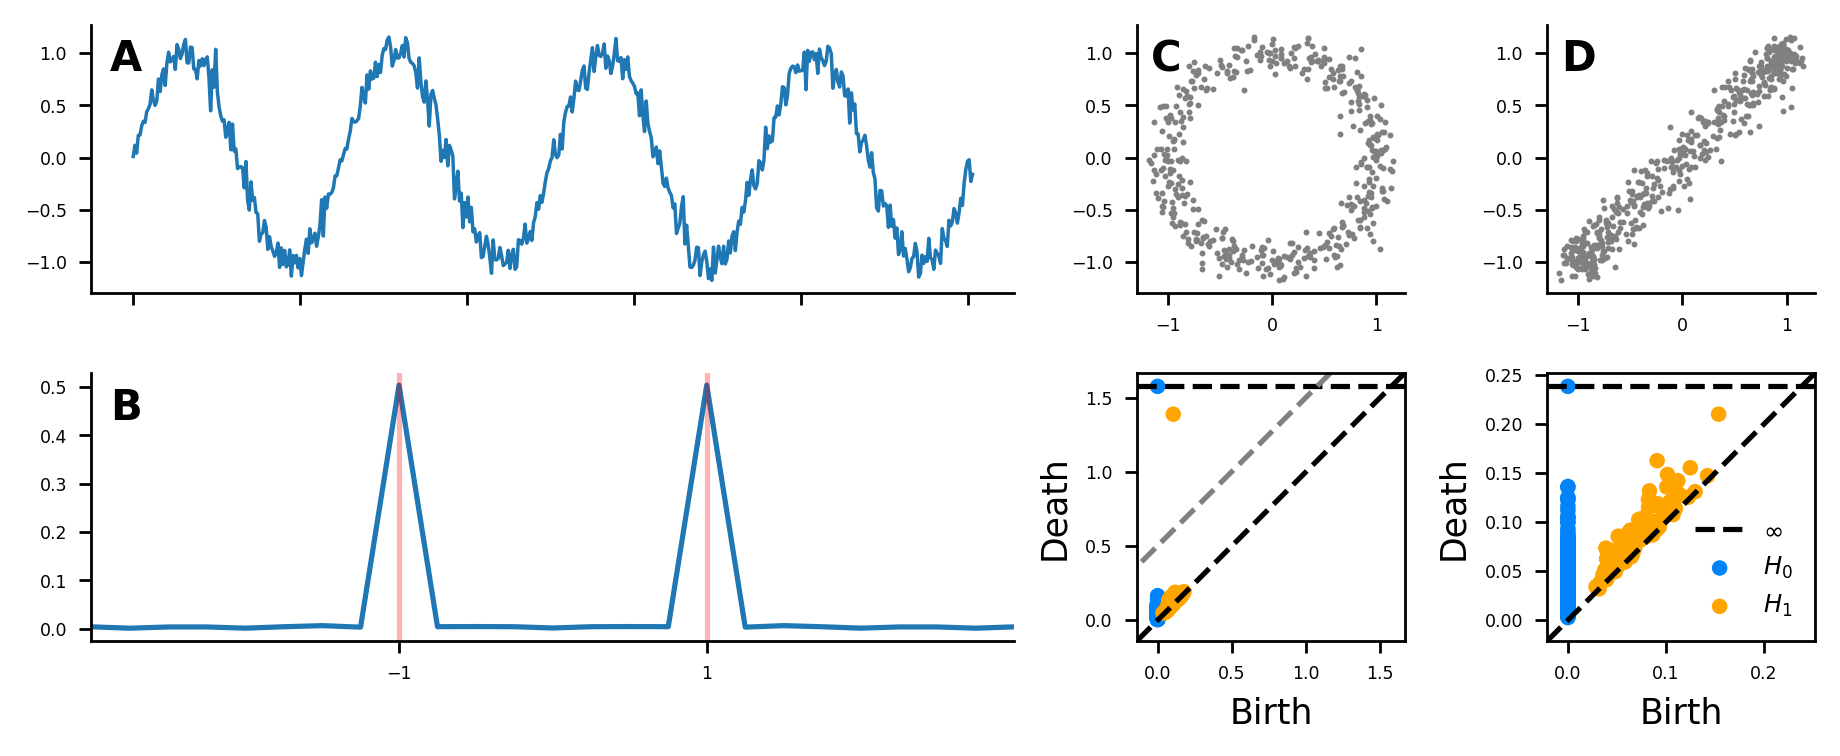

In [309]:
import utils
# Create figure with 3D subplots
fig = plt.figure(figsize=(9, 3.2),dpi=250)

# Create 3D subplots
gs = fig.add_gridspec(
    2, 3, 
    height_ratios=[1, 1],  # Top row 3x taller than bottom row
    width_ratios=[3, 1,1],   # Equal column widths
    wspace=0.2,            # Adjust column spacing (0.3 is default)
    hspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(x, fx,linewidth=1)
ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_xticklabels([])
ax.text(0.02, 0.95, 'A', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax = fig.add_subplot(gs[1, 0])
re.timeseries.plot_frequency_peaks(freqs, coefs, peaks, ax)
ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_xlim(-3, 3)
ax.text(0.02, 0.95, 'B', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

# Plot embeddings
ax_A = fig.add_subplot(gs[0, 1])
ax_A.scatter(embedding[:, 0], embedding[:, 1],marker='.',color="gray",s=2)
ax_A.axis("square")
ax_A.text(0.05, 0.95, 'C', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_A.tick_params(axis='both', which='major', labelsize=5)
ax_A.spines[["top", "right"]].set_visible(False)

ax_B = fig.add_subplot(gs[0, 2])
ax_B.scatter(bad_embedding[:, 0], bad_embedding[:, 1],marker='.',color="gray",s=2)
ax_B.tick_params(axis='both', which='major', labelsize=5)
ax_B.axis("square")
ax_B.spines[["top", "right"]].set_visible(False)
ax_B.text(0.05, 0.95, 'D', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
MAXDIM = 1
rips = Rips(maxdim=MAXDIM)
diags=rips.fit_transform(embedding)

ax = fig.add_subplot(gs[1, 1])
utils.plot_diagrams(diags,color_list,legend=False,ax = ax)
b_values = np.linspace(-10, 5, 15)
d_values = b_values + lower_bound
ax.plot(b_values, d_values, linestyle="--", color="gray")
ax.tick_params(axis='both', which='major', labelsize=5)
diags=rips.fit_transform(bad_embedding)
ax = fig.add_subplot(gs[1, 2])
utils.plot_diagrams(diags,color_list,legend=True,ax = ax)
ax.tick_params(axis='both', which='major', labelsize=5)
plt.savefig("Figures/example_sine_embedding.png",bbox_inches='tight')
plt.show()

In [189]:
def time_adjacency_matrix():
    def inner_time_adjacency_matrix(simplex_j, simplex_i):
        if are_simplices_adjacent(simplex_j, simplex_i):
            return time_weight(simplex_i, simplex_j)
        else:
            return 0

    return inner_time_adjacency_matrix

def time_label(simplex_i):
    return np.mean(simplex_i)

def time_weight(simp1, simp2) -> float:
    return np.abs(time_label(simp1) - time_label(simp2))

def are_simplices_adjacent(simplex1, simplex2):
    # Count common elements between the two tuples
    common_elements = set(simplex1).intersection(set(simplex2))
    # Two simplices are adjacent if they share exactly n-1 elements
    if len(common_elements) == len(simplex1) - 1:
        return 1
    return 0


def time_basic_matrix(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
      simplex_i = inv_row_map[i]
      weight_matrix[i,i] = np.abs(simplex_i[0]-simplex_i[1])
    return weight_matrix


def absolute_time_difference(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
        simplex_i = inv_row_map[i]
        for j in range(n):
            simplex_j = inv_row_map[j]
            union_set = set(simplex_i).union(simplex_j)
            sorted_union = sorted(union_set)
            weight_matrix[i,j] = np.abs(sorted_union[0]-sorted_union[-1])
    return weight_matrix

def edge_length_function(points):
    def edge_length(simp1, simp2):
        if simp1 == simp2:
            return np.linalg.norm(points[simp1[0]] - points[simp1[1]])
        else:
            return 0

    return edge_length


#W_global = absolute_time_difference(n_simplices)
#global_cycle = optimize_cycle(W_global, x_orig, boundary_matrix, n_simplices)

In [188]:
# get all cycles bigger than the given bound
rips = Rips(maxdim=MAXDIM)
diags=rips.fit_transform(embedding)
persistence = diags[1][:, 1] - diags[1][:, 0]
cycles = np.argwhere(persistence > lower_bound).flatten()
birth, death = diags[1][cycles[0]]
# use death to calculate max_edge_length
max_edge_length = death * 1.01  # give a bit of slack

dimension = 2
points = embedding
min_persistence = lower_bound
#min_persistence = 0.4


gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
(
    representative,
    boundary_map,
    reduced_boundary_base,
    (birth_simplex,death_simplex)
) = re.core.get_representative_and_complex(gudhi_complex, dimension)

# Get the ACTUAL values of birth and death
birth,death = gudhi_complex.filtration(birth_simplex),gudhi_complex.filtration(death_simplex)
#min_persistence = (death - birth)*0.95

order_function = lambda s: (gudhi_complex.filtration(s), s)
# ISOLATED
np1_simplices = sorted(
    {
        simplex
        for simplex in reduced_boundary_base
        if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
n_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
nm1_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
        
x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [190]:
W = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix())
#W = None

# Run optimization
x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
    boundary_matrix, x_orig, W, use_gurobi=True
)
mean_cycle = set(
    [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
)  # be carefull here with values close to zero, add a tolerance parameter


W = time_basic_matrix(n_simplices)
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=True) 
local_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

W = re.core.create_weight_matrix(n_simplices, edge_length_function(points))
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=True) 
len_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/c6044ca5517c42508b7ce348af310384-pulp.lp
Reading time = 0.08 seconds
OBJ: 27606 rows, 82349 columns, 136623 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27606 rows, 82349 columns and 136623 nonzeros
Model fingerprint: 0xd15ed83a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+03, 3e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve removed 24618 rows and 24618 columns
Presolve time: 0.08s
Presolved: 2988 rows, 57731 columns, 123410 nonzeros

Concurrent 

In [215]:

def plot_selection(x,fx,cycle,color,ax):
    vertex_set = {item for tup in cycle for item in tup}
    for vertex in vertex_set:
        plt.axvline(x[vertex], color=color, alpha=0.4,linewidth=1)
    
    ax.plot(x, fx,alpha=0.8,color="gray")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=5)
    plt.scatter(x[list(vertex_set)],fx[list(vertex_set)],color=color,s=20,edgecolors="white",linewidths=1,zorder=2)
    ax.set_xticklabels([])

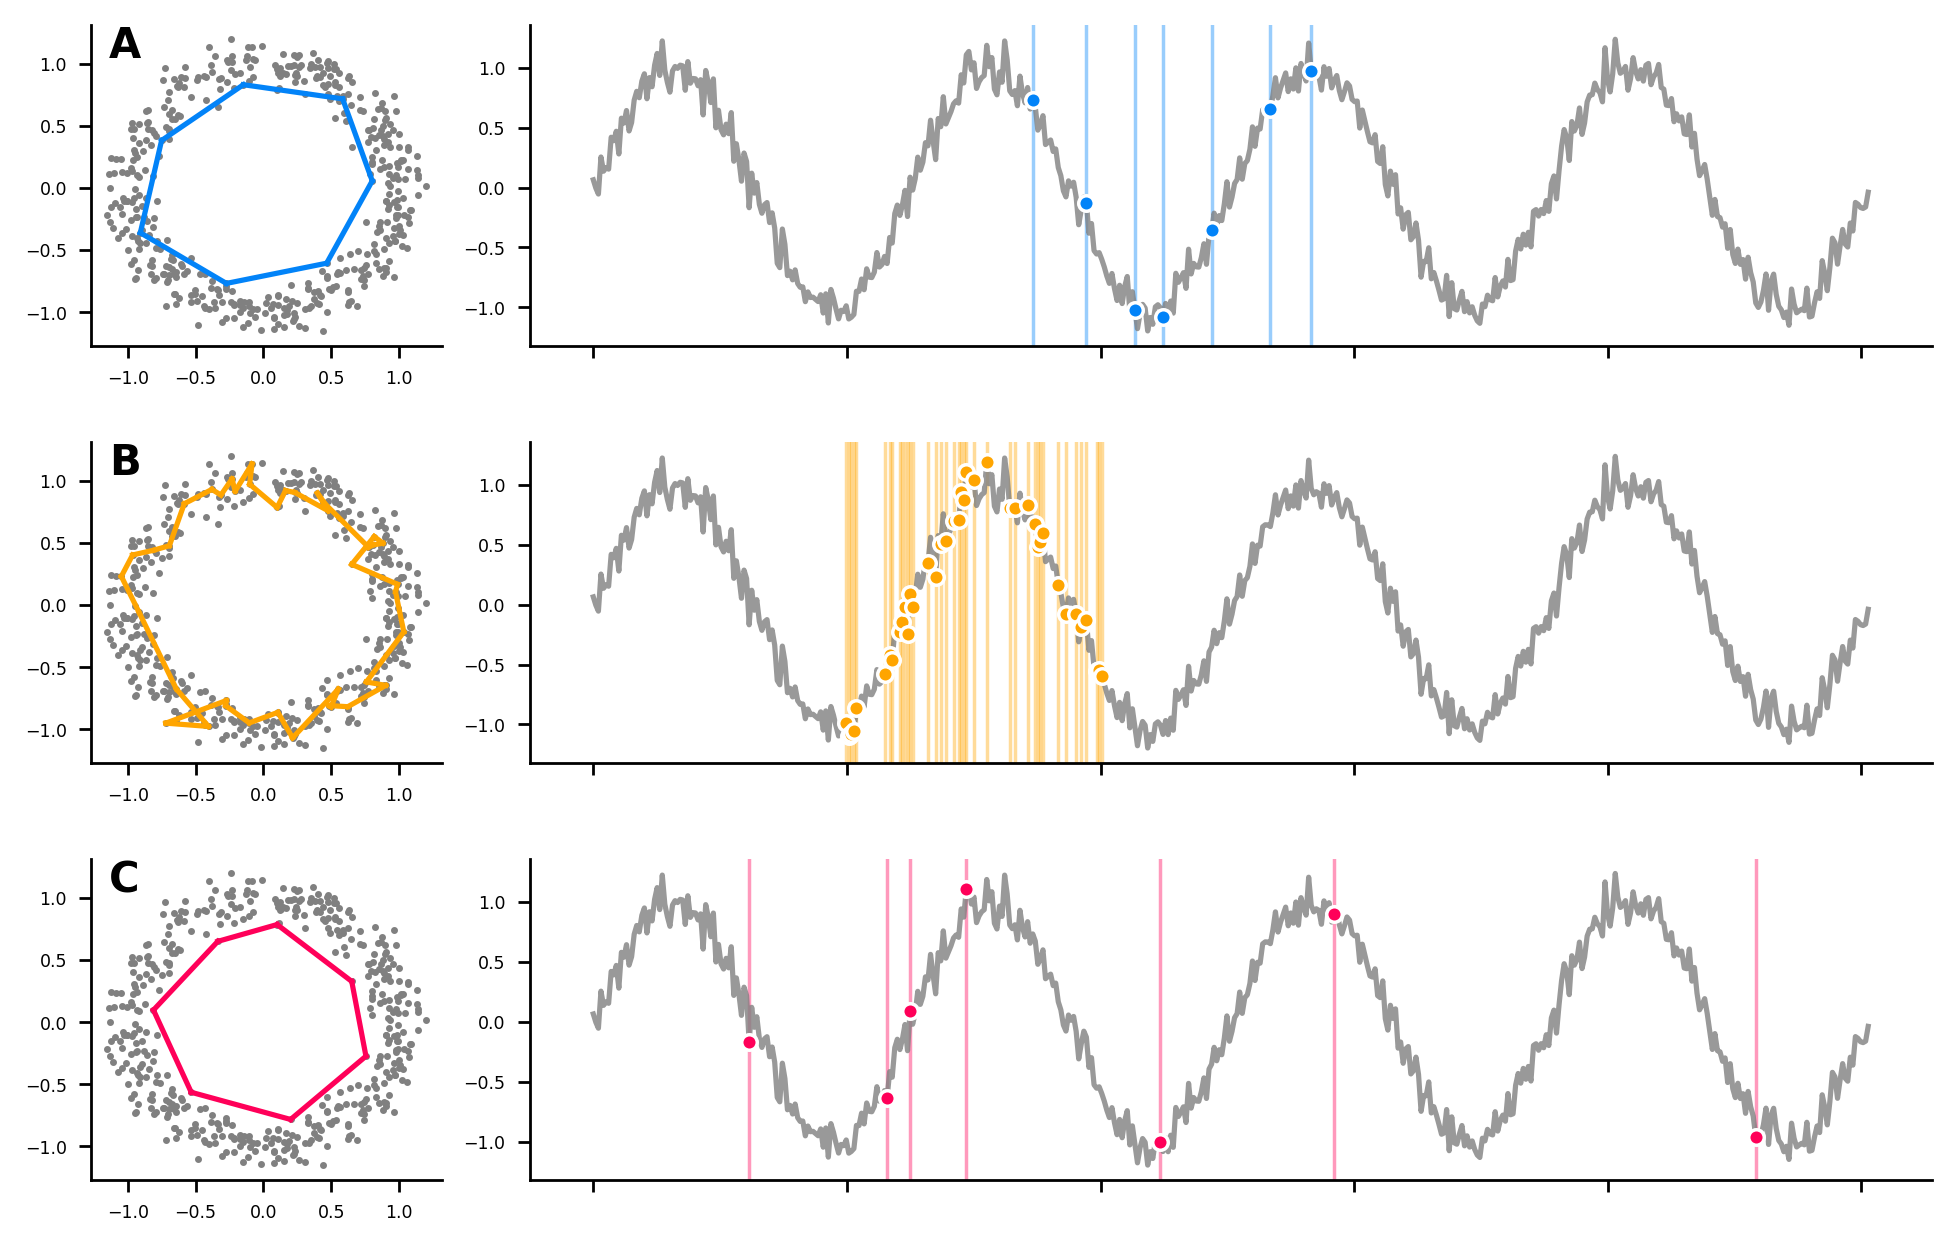

In [279]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 6), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    3, 2, 
    height_ratios=[1,1,1],  # Equal height for both rows
    width_ratios=[1, 4],  # Wider right column, smaller left column
    wspace=0.1,  # Slight space between columns (you can adjust this)
    hspace=0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[0, 0])
ax_A.spines[["top", "right"]].set_visible(False)
ax_A.plot(*zip(*points), ".",color="gray",ms=2)
ax_A.tick_params(axis='both', which='major', labelsize=5)
for edge in mean_cycle:
    ax_A.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["blue"], alpha=1)
ax_A.text(0.05, 1, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_B = fig.add_subplot(gs[1, 0])
ax_B.plot(*zip(*points), ".",color="gray",ms=2)
for edge in local_cycle:
    ax_B.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["orange"], alpha=1)
ax_B.text(0.05, 1, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_B.spines[["top", "right"]].set_visible(False)
ax_B.tick_params(axis='both', which='major', labelsize=5)

ax_C = fig.add_subplot(gs[2, 0])
ax_C.plot(*zip(*points), ".",color="gray",ms=2)
for edge in len_cycle:
    ax_C.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["red"], alpha=1)
ax_C.text(0.05, 1, 'C', transform=ax_C.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_C.spines[["top", "right"]].set_visible(False)
ax_C.tick_params(axis='both', which='major', labelsize=5)


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[0, 1])
plot_selection(x,fx,mean_cycle,colors["blue"],ax)

# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x,fx,local_cycle,colors["orange"],ax)

# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[2, 1])
plot_selection(x,fx,len_cycle,colors["red"],ax)
plt.savefig("Figures/example_sine_representative_lower_bound.png",bbox_inches='tight')
plt.show()

# Constrained Version

In [206]:
# get all cycles bigger than the given bound
rips = Rips(maxdim=MAXDIM)
diags=rips.fit_transform(embedding)
persistence = diags[1][:, 1] - diags[1][:, 0]
cycles = np.argwhere(persistence > lower_bound).flatten()
birth, death = diags[1][cycles[0]]
# use death to calculate max_edge_length
max_edge_length = death * 1.01  # give a bit of slack

dimension = 2
points = embedding
#min_persistence = lower_bound
#min_persistence = 0.4


gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
(
    representative,
    boundary_map,
    reduced_boundary_base,
    (birth_simplex,death_simplex)
) = re.core.get_representative_and_complex(gudhi_complex, dimension)

# Get the ACTUAL values of birth and death
birth,death = gudhi_complex.filtration(birth_simplex),gudhi_complex.filtration(death_simplex)
min_persistence = (death - birth)*0.95

order_function = lambda s: (gudhi_complex.filtration(s), s)
# ISOLATED
np1_simplices = sorted(
    {
        simplex
        for simplex in reduced_boundary_base
        if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
n_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
nm1_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
        
x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [207]:
W = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix())
#W = None

# Run optimization
x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
    boundary_matrix, x_orig, W, use_gurobi=True
)
cons_mean_cycle = set(
    [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
)  # be carefull here with values close to zero, add a tolerance parameter


W = time_basic_matrix(n_simplices)
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=True) 
cons_local_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

W = re.core.create_weight_matrix(n_simplices, edge_length_function(points))
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=True) 
cons_len_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/0789ac5632c64247bf9702437bc0da75-pulp.lp
Reading time = 0.01 seconds
OBJ: 5621 rows, 16394 columns, 26698 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5621 rows, 16394 columns and 26698 nonzeros
Model fingerprint: 0xa979b17c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve removed 4547 rows and 4577 columns
Presolve time: 0.02s
Presolved: 1074 rows, 11817 columns, 27027 nonzeros

Iteration    Objec

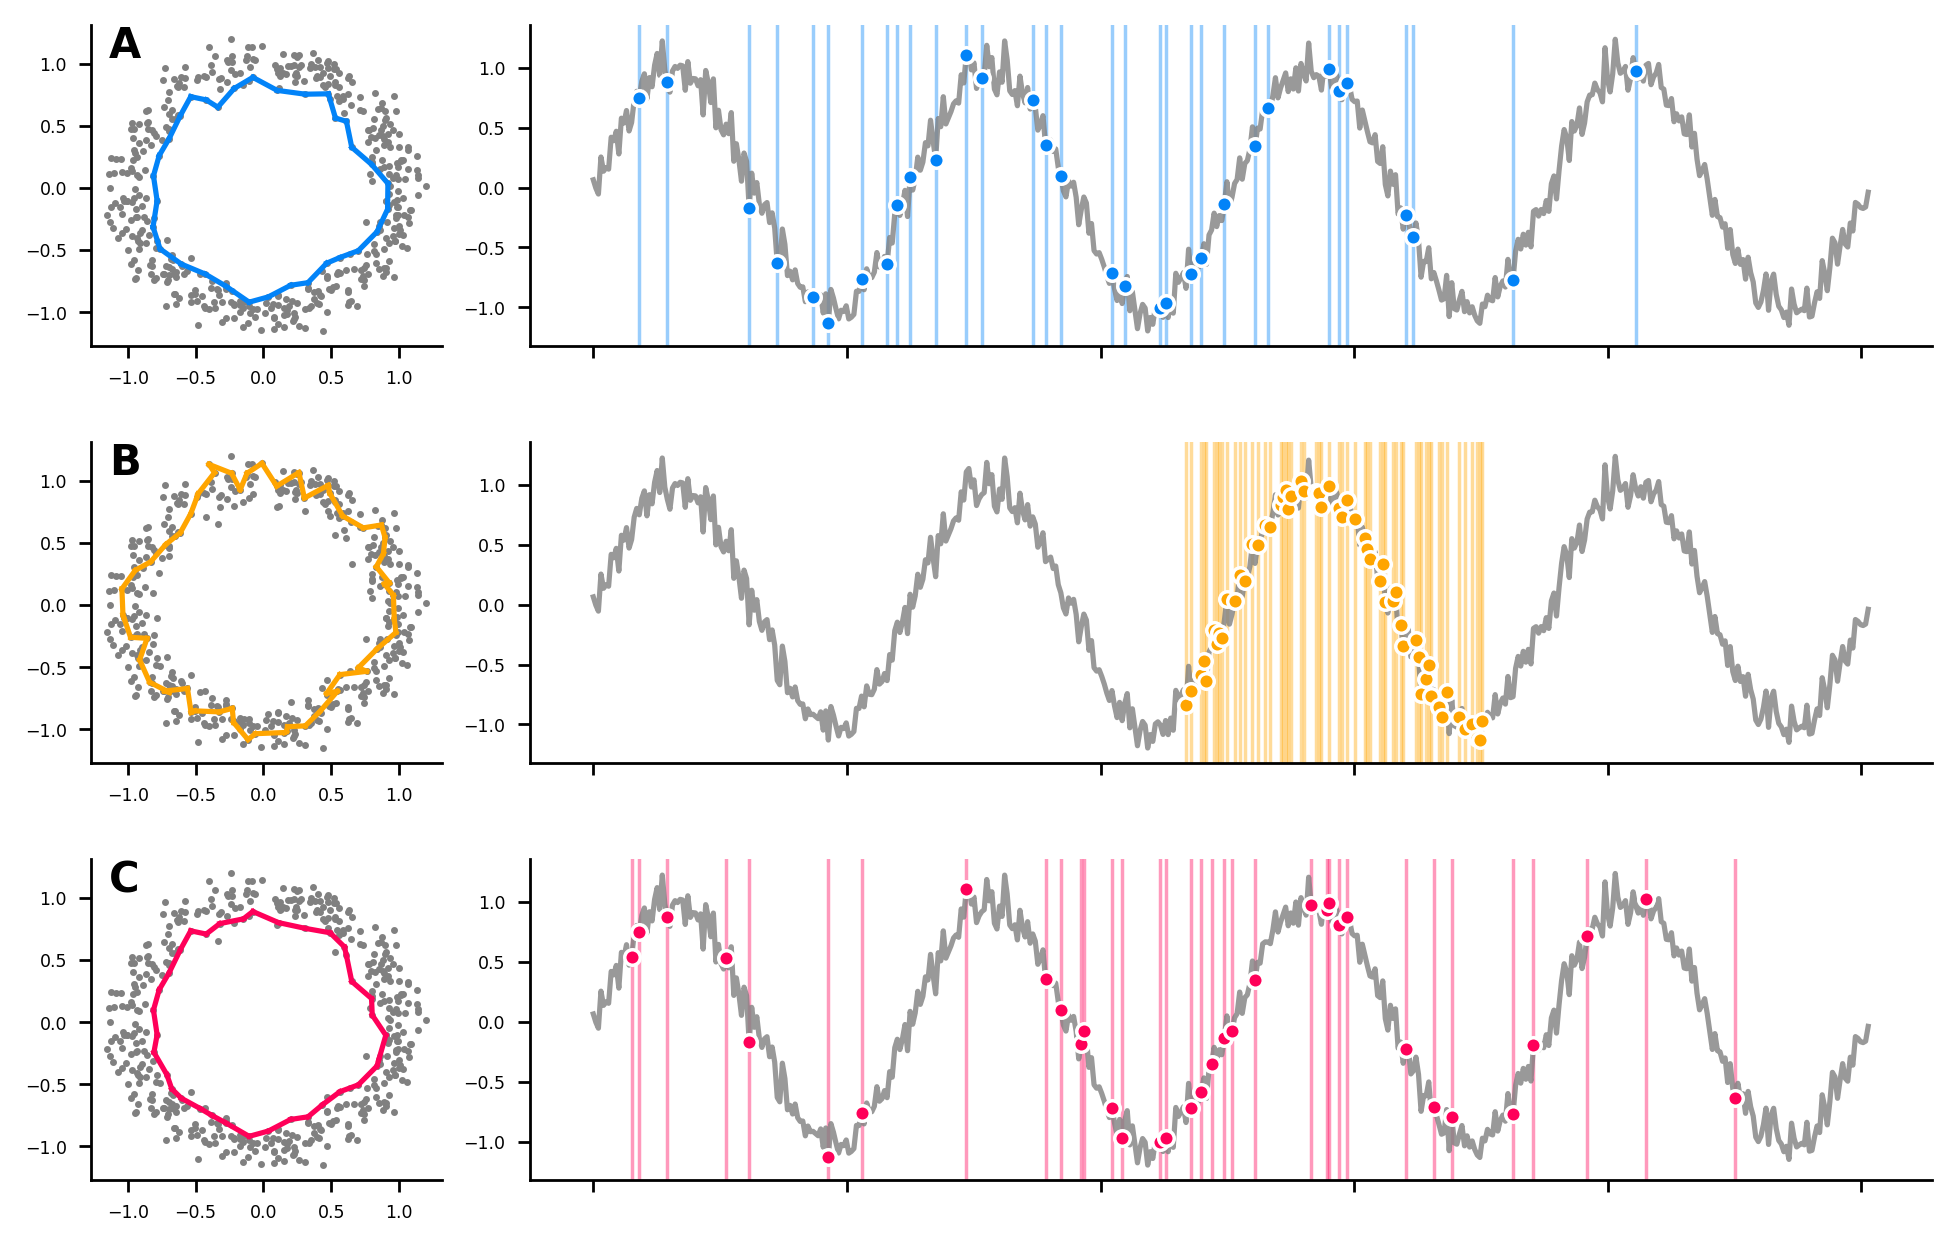

In [277]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 6), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    3, 2, 
    height_ratios=[1,1,1],  # Equal height for both rows
    width_ratios=[1, 4],  # Wider right column, smaller left column
    wspace=0.1,  # Slight space between columns (you can adjust this)
    hspace=0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[0, 0])
ax_A.spines[["top", "right"]].set_visible(False)
ax_A.plot(*zip(*points), ".",color="gray",ms=2)
ax_A.tick_params(axis='both', which='major', labelsize=5)
for edge in cons_mean_cycle:
    ax_A.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["blue"], alpha=1)


ax_A.text(0.05, 1, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_B = fig.add_subplot(gs[1, 0])
ax_B.plot(*zip(*points), ".",color="gray",ms=2)
for edge in cons_local_cycle:
    ax_B.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["orange"], alpha=1)
ax_B.text(0.05, 1, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_B.spines[["top", "right"]].set_visible(False)
ax_B.tick_params(axis='both', which='major', labelsize=5)

ax_C = fig.add_subplot(gs[2, 0])
ax_C.plot(*zip(*points), ".",color="gray",ms=2)
for edge in cons_len_cycle:
    ax_C.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["red"], alpha=1)
ax_C.text(0.05, 1, 'C', transform=ax_C.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_C.spines[["top", "right"]].set_visible(False)
ax_C.tick_params(axis='both', which='major', labelsize=5)


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[0, 1])
plot_selection(x,fx,cons_mean_cycle,colors["blue"],ax)

# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x,fx,cons_local_cycle,colors["orange"],ax)

ax = fig.add_subplot(gs[2, 1])
plot_selection(x,fx,cons_len_cycle,colors["red"],ax)
plt.savefig("Figures/example_sine_representative_95_persistence.png",bbox_inches='tight')
plt.show()

# compare with distance

In [269]:
# get all cycles bigger than the given bound
rips = Rips(maxdim=MAXDIM)
diags=rips.fit_transform(embedding)
persistence = diags[1][:, 1] - diags[1][:, 0]
cycles = np.argwhere(persistence > lower_bound).flatten()
birth, death = diags[1][cycles[0]]
# use death to calculate max_edge_length
max_edge_length = death * 1.01  # give a bit of slack

dimension = 2
points = embedding
#min_persistence = lower_bound
#min_persistence = 0.4


gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
(
    representative,
    boundary_map,
    reduced_boundary_base,
    (birth_simplex,death_simplex)
) = re.core.get_representative_and_complex(gudhi_complex, dimension)

# Get the ACTUAL values of birth and death
birth,death = gudhi_complex.filtration(birth_simplex),gudhi_complex.filtration(death_simplex)
min_persistence = (death - birth)

order_function = lambda s: (gudhi_complex.filtration(s), s)
# ISOLATED
np1_simplices = sorted(
    {
        simplex
        for simplex in reduced_boundary_base
        if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
n_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
nm1_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
        
x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [270]:
W = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix())
#W = None

# Run optimization
x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
    boundary_matrix, x_orig, W, use_gurobi=True
)
full_mean_cycle = set(
    [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
)  # be carefull here with values close to zero, add a tolerance parameter


W = time_basic_matrix(n_simplices)
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=True) 
full_local_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

W = re.core.create_weight_matrix(n_simplices, edge_length_function(points))
x_alt, status, objective_value = re.core.find_minimal_homologous_cycle(boundary_matrix, x_orig,W,use_gurobi=True) 
full_len_cycle = set([n_simplices[index] for index in np.argwhere(~np.isclose(x_alt,0)).flatten()])

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/fb7f9e8f1c9647469c54cf8e70078220-pulp.lp
Reading time = 0.01 seconds
OBJ: 3180 rows, 9063 columns, 14469 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3180 rows, 9063 columns and 14469 nonzeros
Model fingerprint: 0x643a27cb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve removed 2472 rows and 2530 columns
Presolve time: 0.01s
Presolved: 708 rows, 6533 columns, 15208 nonzeros

Iteration    Objective

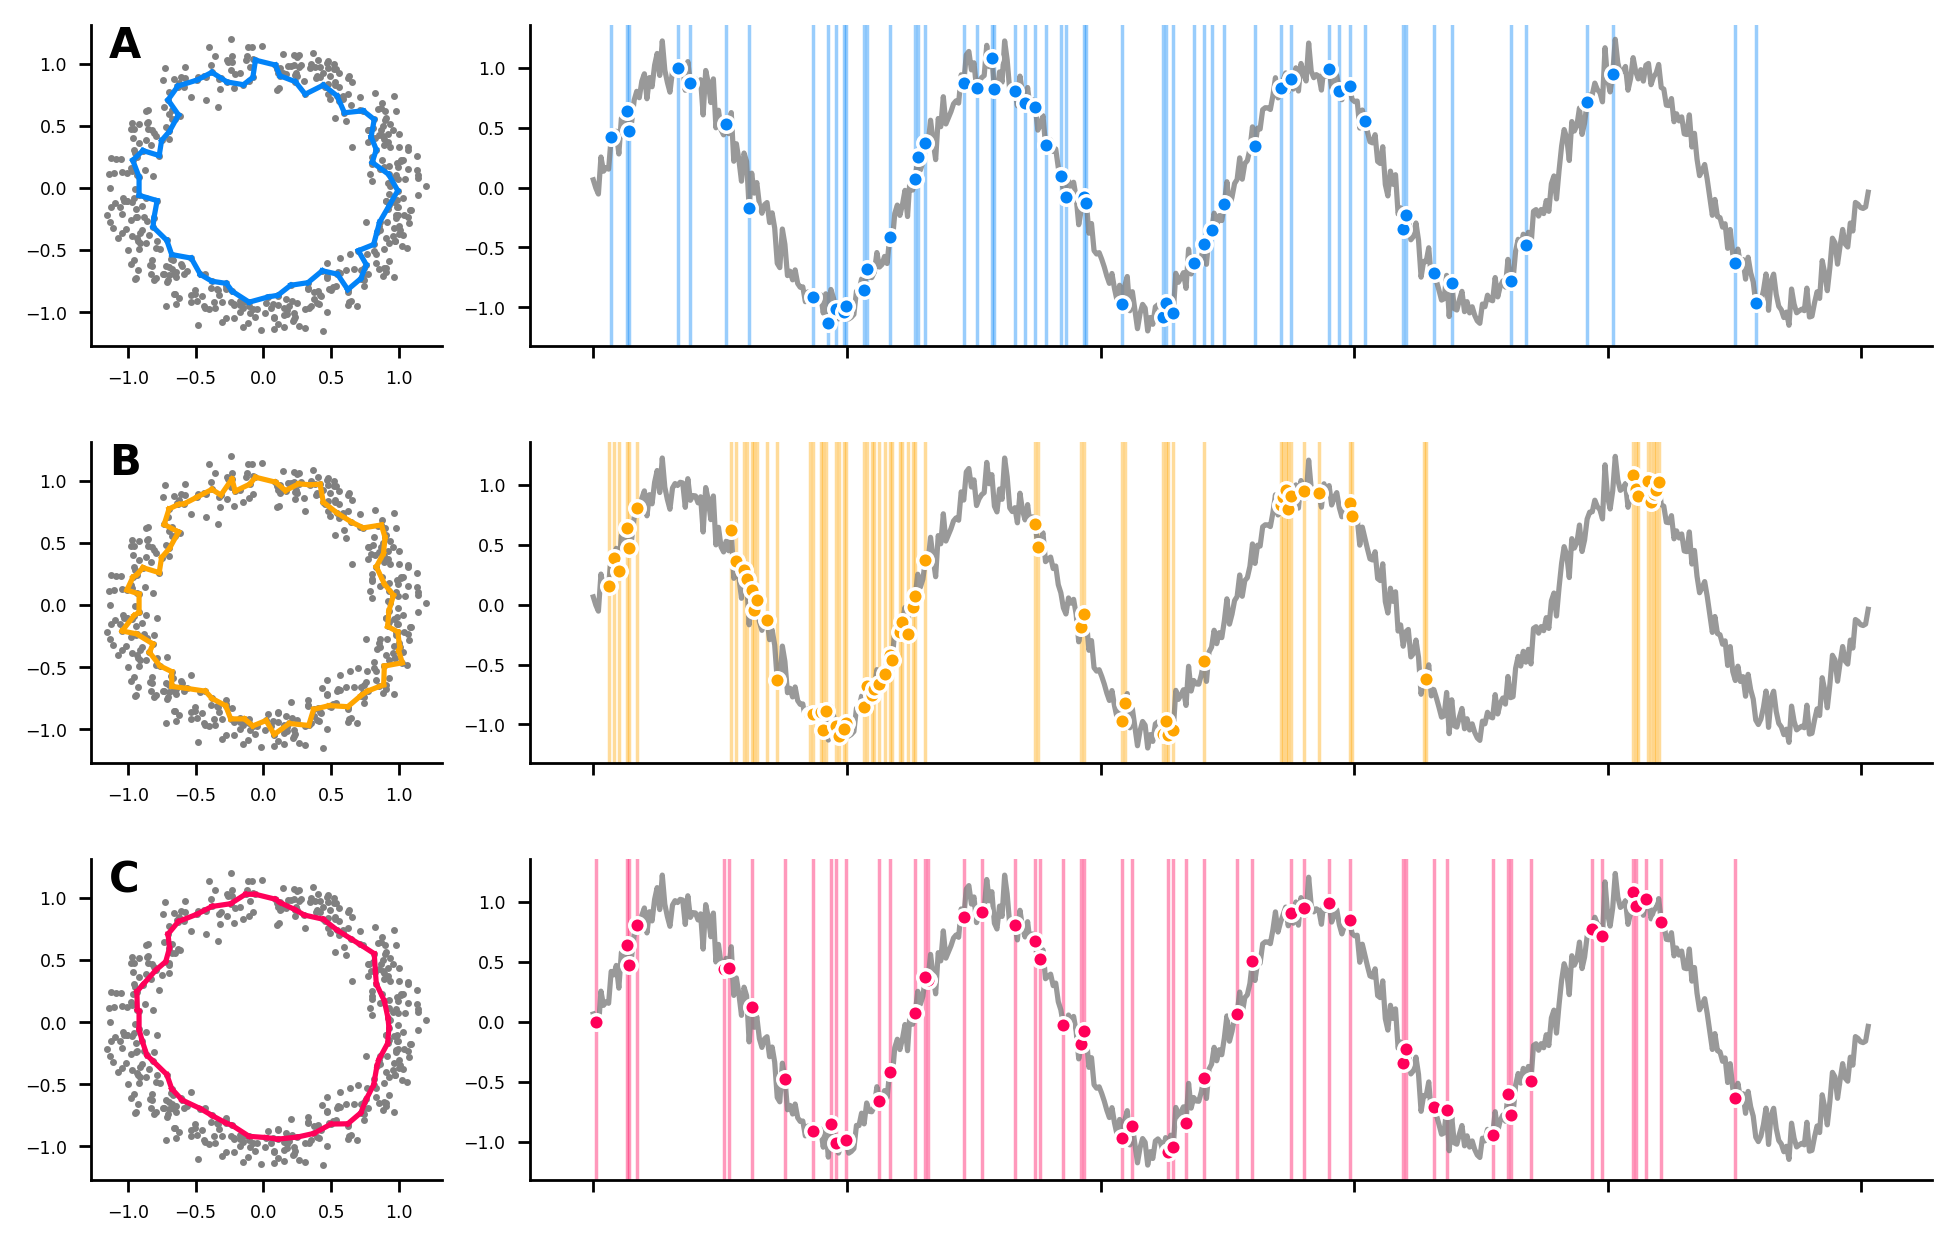

In [278]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 6), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    3, 2, 
    height_ratios=[1,1,1],  # Equal height for both rows
    width_ratios=[1, 4],  # Wider right column, smaller left column
    wspace=0.1,  # Slight space between columns (you can adjust this)
    hspace=0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[0, 0])
ax_A.spines[["top", "right"]].set_visible(False)
ax_A.plot(*zip(*points), ".",color="gray",ms=2)
ax_A.tick_params(axis='both', which='major', labelsize=5)
for edge in full_mean_cycle:
    ax_A.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["blue"], alpha=1)


ax_A.text(0.05, 1, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_B = fig.add_subplot(gs[1, 0])
ax_B.plot(*zip(*points), ".",color="gray",ms=2)
for edge in full_local_cycle:
    ax_B.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["orange"], alpha=1)
ax_B.text(0.05, 1, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_B.spines[["top", "right"]].set_visible(False)
ax_B.tick_params(axis='both', which='major', labelsize=5)

ax_C = fig.add_subplot(gs[2, 0])
ax_C.plot(*zip(*points), ".",color="gray",ms=2)
for edge in full_len_cycle:
    ax_C.plot(*zip(points[edge[0]], points[edge[1]]), "-", color=colors["red"], alpha=1)
ax_C.text(0.05, 1, 'C', transform=ax_C.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
ax_C.spines[["top", "right"]].set_visible(False)
ax_C.tick_params(axis='both', which='major', labelsize=5)


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[0, 1])
plot_selection(x,fx,full_mean_cycle,colors["blue"],ax)

# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x,fx,full_local_cycle,colors["orange"],ax)

ax = fig.add_subplot(gs[2, 1])
plot_selection(x,fx,full_len_cycle,colors["red"],ax)
plt.savefig("Figures/example_sine_representative_full_persistence.png",bbox_inches='tight')
plt.show()